In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.7/901.7 kB 53.0 MB/s eta 0:00:00


Loading data to colab

In [3]:
!cp -r "/content/drive/Othercomputers/My laptop/GoogleDriveShared/val.7z" /content/

In [4]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 37.2 MB/s eta 0:00:00


In [5]:
import py7zr

with py7zr.SevenZipFile("/content/val.7z", 'r') as archive:
     archive.extract(path="/content")

In [7]:
!cp -r "/content/drive/Othercomputers/My laptop/GoogleDriveShared/train.7z" /content/

In [8]:
import py7zr

with py7zr.SevenZipFile("/content/train.7z", 'r') as archive:
     archive.extract(path="/content")

In [ ]:
from ultralytics import YOLO
import torch
from tqdm import tqdm
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

def plot_image_with_bboxes(image_path, label_path):
    """
    Display an image with bounding boxes drawn based on YOLO labels.

    Args:
    - image_path (str): Path to the image file.
    - label_path (str): Path to the YOLO label file corresponding to the image.
    """
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    # Get image dimensions
    height, width, _ = image.shape

    # Read YOLO label file
    with open(label_path, 'r') as f:
        labels = f.readlines()

    # Draw bounding boxes
    for label in labels:
        parts = label.strip().split()
        class_id, x_center, y_center, box_width, box_height = map(float, parts)

        # Denormalize the coordinates
        x_center *= width
        y_center *= height
        box_width *= width
        box_height *= height

        # Calculate top-left and bottom-right corners
        x_min = int(x_center - box_width / 2)
        y_min = int(y_center - box_height / 2)
        x_max = int(x_center + box_width / 2)
        y_max = int(y_center + box_height / 2)

        # Draw the bounding box
        color = (255, 0, 0)  # Red color for bounding boxes
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, f'Class {int(class_id)}', (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    # plt.axis('off')
    plt.show()

In [ ]:
# create folders if not exist
folder_crops = {'train': '/content/drive/Othercomputers/My laptop/GoogleDriveShared/train/images/',
                'val': '/content/drive/Othercomputers/My laptop/GoogleDriveShared/val/images/'}

folder_labels = {'train': '/content/drive/Othercomputers/My laptop/GoogleDriveShared/train/labels/',
                 'val': '/content/drive/Othercomputers/My laptop/GoogleDriveShared/val/labels/'}


def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

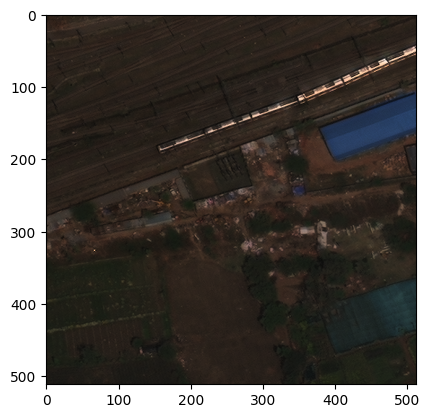

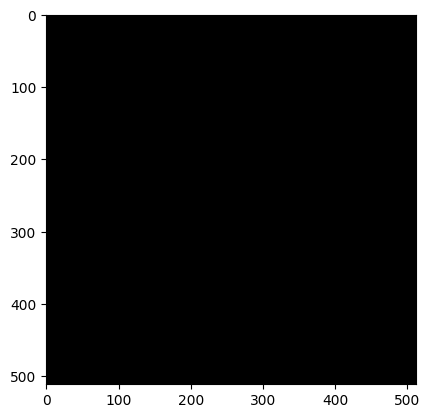

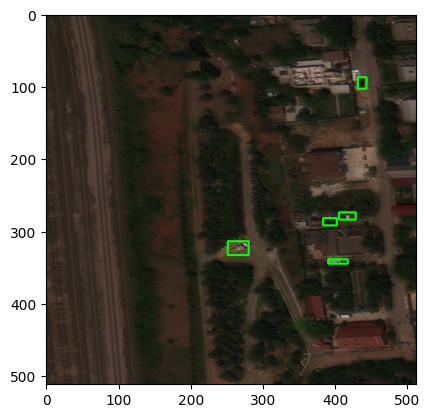

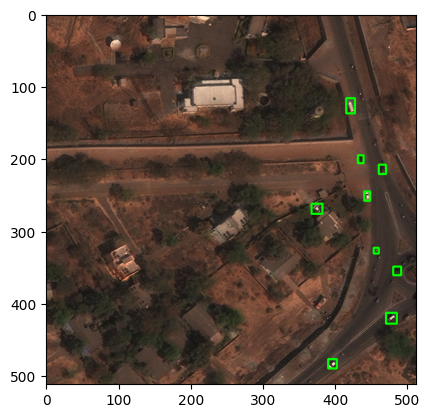

In [ ]:
crop_size = 512
for idx, sample in enumerate(np.random.choice(os.listdir(folder_crops['train']), 4)):

    # Load image and corresponding labels
    image = imread(os.path.join(folder_crops['train'], sample))
    with open(os.path.join(folder_labels['train'], sample.replace('.tif', '.txt')), 'r') as f:
        labels = f.readlines()

    for box in labels:
        box = np.array([d for d in box.split(' ')], dtype=np.float32)

        # Undo coordinate normalization
        x_center = box[1] * crop_size
        y_center = box[2] * crop_size

        width = box[3] * crop_size
        height = box[4] * crop_size

        # Convert from YOLOv8 format to OpenCV rectangle format
        x_start, y_start = int(x_center - width/2), int(y_center - height/2)
        x_end, y_end = int(x_center + width/2), int(y_center + height/2)

        cv2.rectangle(image, (x_start, y_start), (x_end, y_end), color=(0, 255, 0), thickness=2)
    plt.figure()
    plt.imshow(image)

In [ ]:
model = YOLO("yolov8s.pt")
model.info()

YOLOv8m summary: 295 layers, 25,902,640 parameters, 0 gradients, 79.3 GFLOPs


(295, 25902640, 0, 79.3204224)

In [ ]:
!yolo version


8.3.51


In [ ]:
config = """
# train and val datasets (image directory or *.txt file with image paths)
train: data/tif_images/train
val: data/tif_images/val

# number of classes
nc: 2

# class names
names: ['Car/Bus', 'Truck']
"""

with open("data.yaml", "w") as f:
    f.write(config)

In [ ]:
root = "C:/Heorhii/cvcourse/cv-course/project"
!yolo task=detect mode=train model=yolov8s.pt data={root}/data.yaml epochs=10 imgsz=512 mosaic=0.0 flipud=0.5 scale=0.0 device=0

New https://pypi.org/project/ultralytics/8.3.52 available ðŸ˜ƒ Update with 'pip install -U ultralytics'
Ultralytics 8.3.51 ðŸš€ Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:/Heorhii/cvcourse/cv-course/project/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_


train: Scanning C:\Heorhii\cvcourse\cv-course\project\data\tif_images\train\labels.cache... 27299 images, 17438 backgrounds, 0 corrupt: 100%|##########| 27299/27299 [00:00<?, ?it/s]
train: Scanning C:\Heorhii\cvcourse\cv-course\project\data\tif_images\train\labels.cache... 27299 images, 17438 backgrounds, 0 corrupt: 100%|##########| 27299/27299 [00:00<?, ?it/s]
OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently p

In [ ]:
# Path to the folder containing the TIFF files
folder_path = Path("data/train_images")

# List all .tif files in the folder (including subfolders)
imfiles = list(folder_path.rglob("*.tif"))
# imfiles

In [ ]:
for idx, sample in enumerate(np.random.choice(imfiles, 4)):
    image = cv2.imread(sample)
    # image = image[1500:, 1500:, :]

    result = model.predict(image, conf=0.2)[0]
    boxes = result.boxes.cpu().numpy().xyxy.astype(np.int16)

    for box_idx, box in enumerate(boxes):
        start, stop = box[0:2], box[2:]
        cv2.rectangle(image, start, stop, color=(0, 255, 0), thickness=5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.putText(image, result.names[result.boxes.cls[box_idx].item()], (box[0], box[1]),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 6, cv2.LINE_AA)
    plt.figure(figsize=(10, 6))
    plt.imshow(image)

In [ ]:

if torch.cuda.is_available():
    print("CUDA is available. PyTorch will use the GPU.")
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch will use the GPU.
